epoch:5, train_loss:0.049, train_acc:0.985, test_acc:0.987
epoch:10, train_loss:0.026, train_acc:0.992, test_acc:0.990
epoch:15, train_loss:0.017, train_acc:0.994, test_acc:0.991
epoch:20, train_loss:0.011, train_acc:0.996, test_acc:0.992


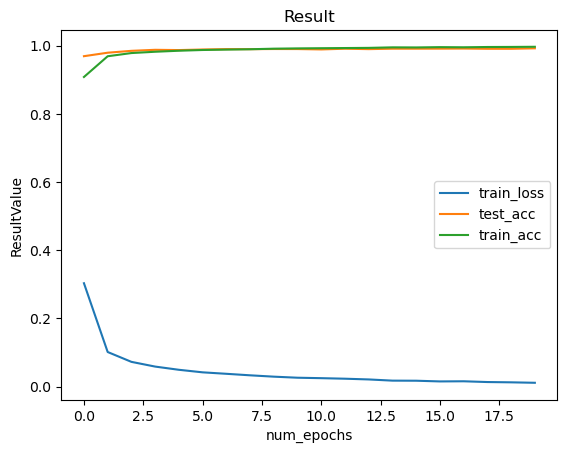

/tmp/ipykernel_8669/1292102007.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(8,8))


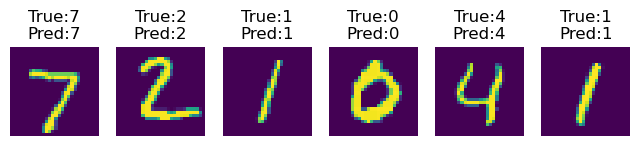

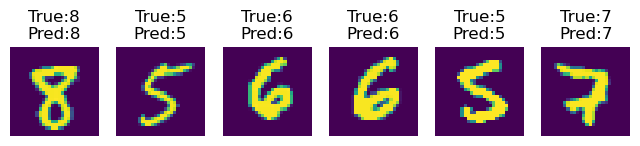

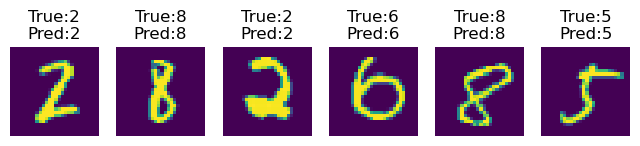

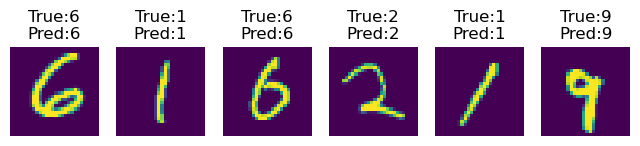

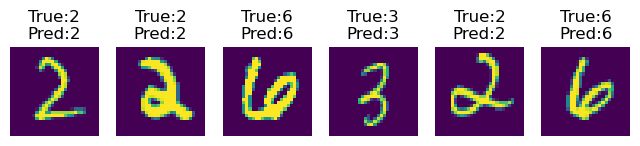

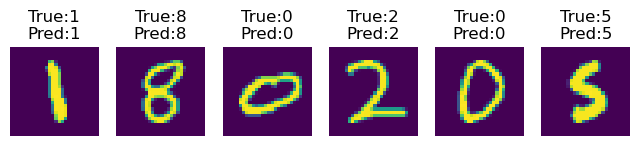

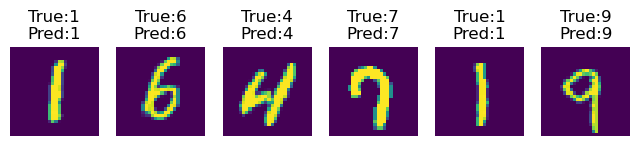

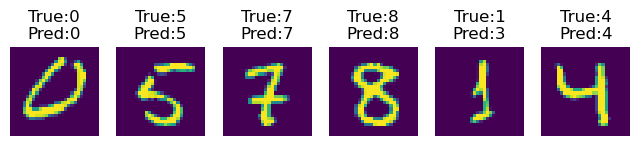

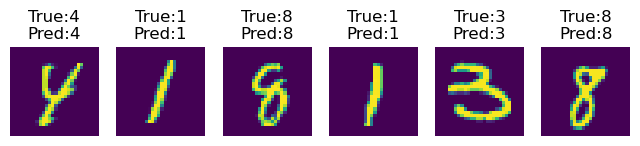

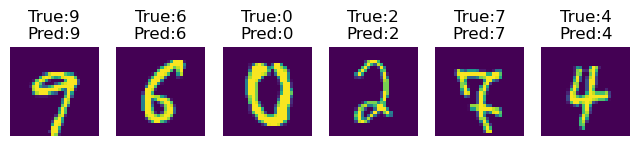

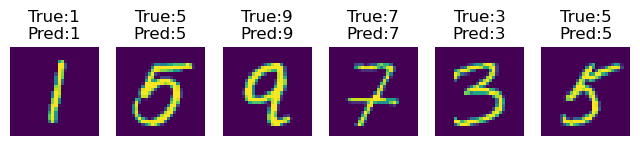

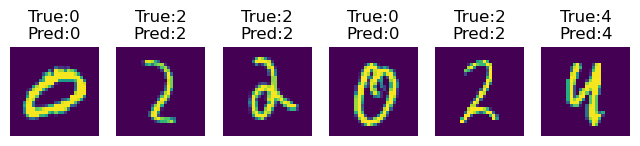

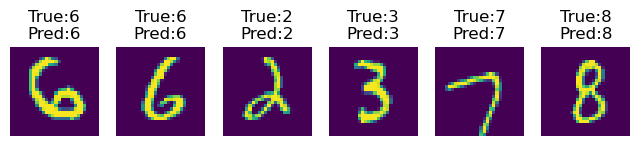

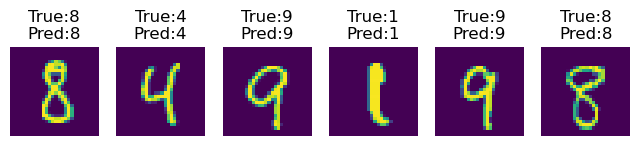

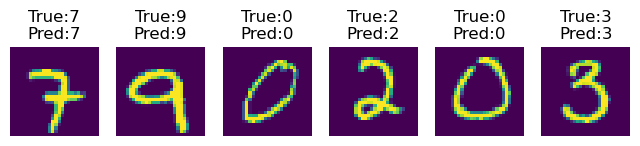

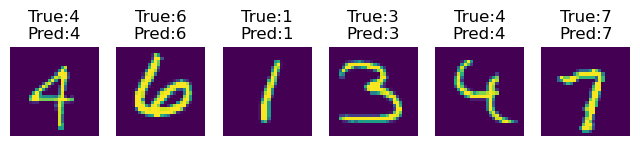

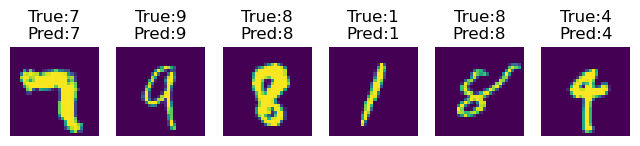

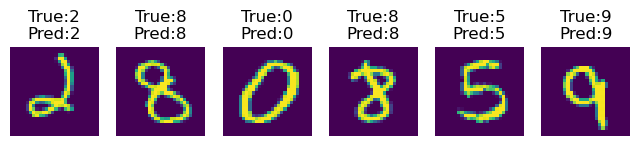

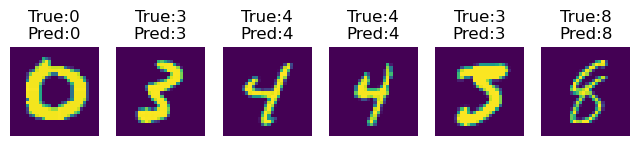

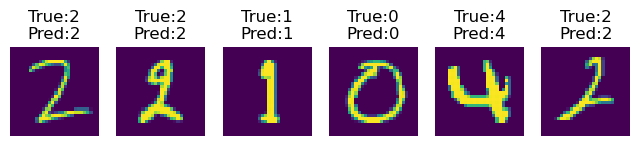

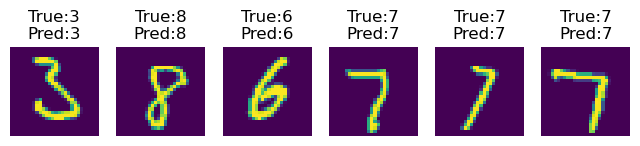

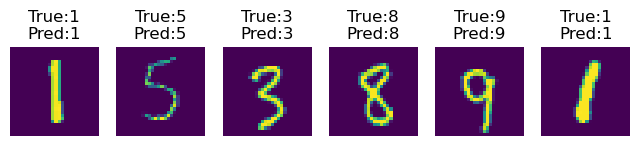

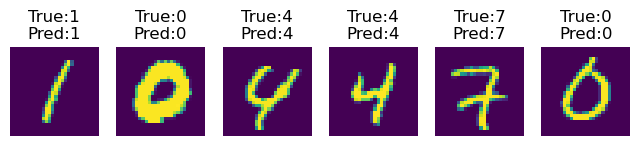

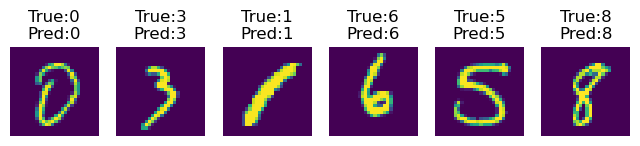

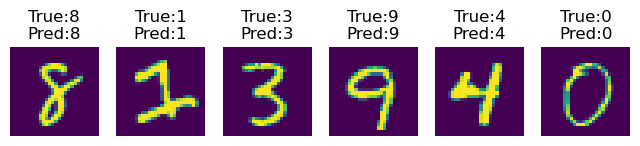

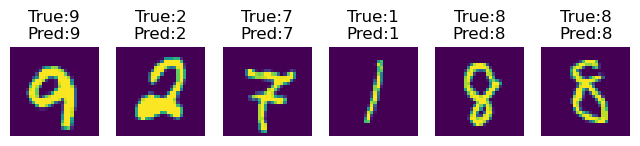

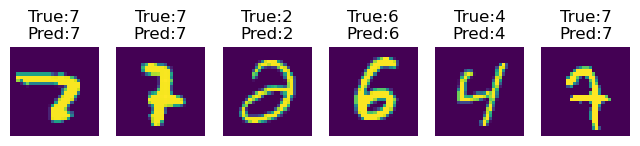

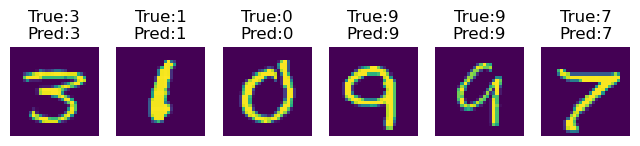

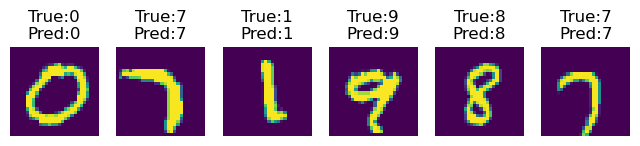

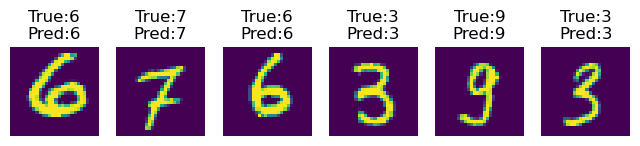

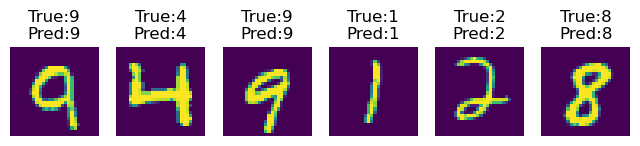

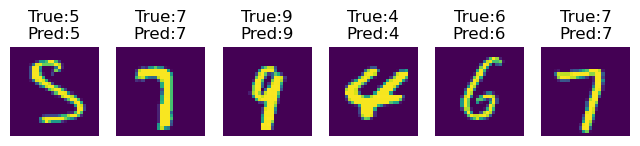

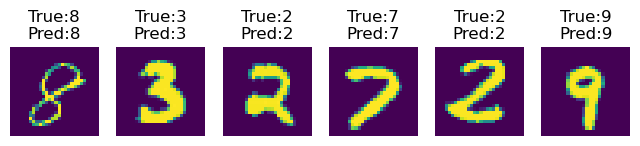

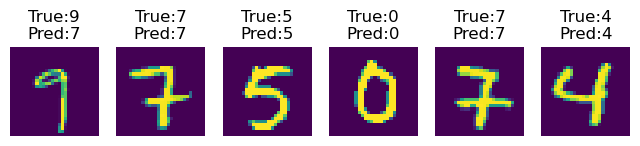

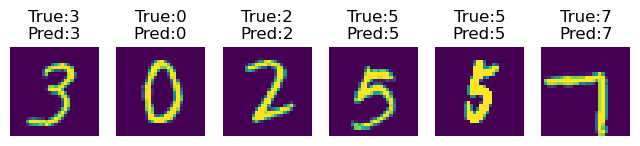

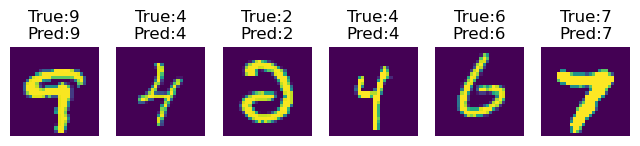

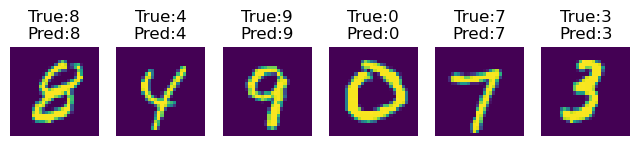

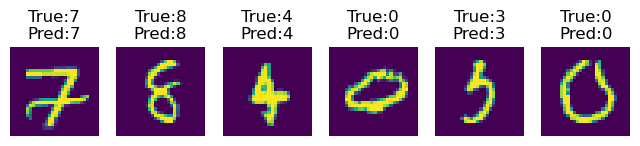

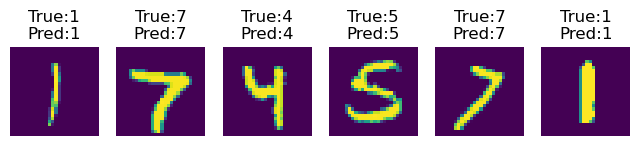

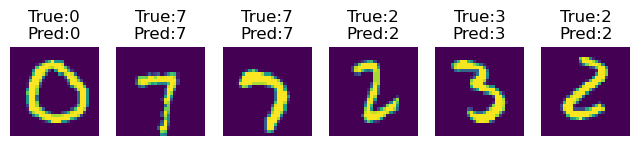

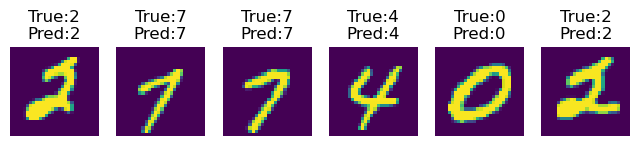

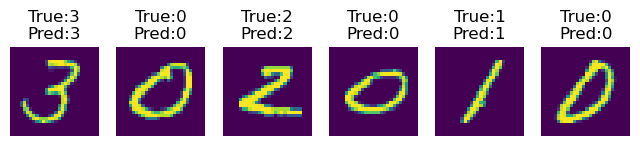

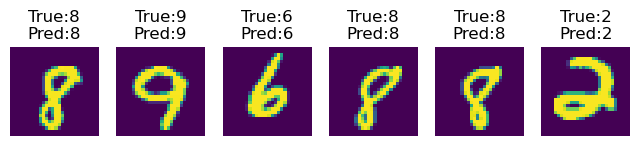

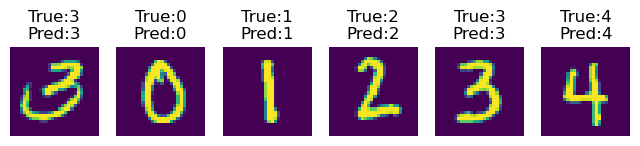

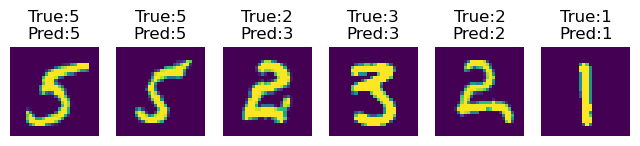

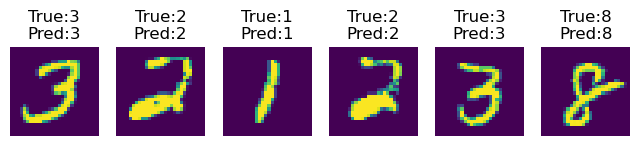

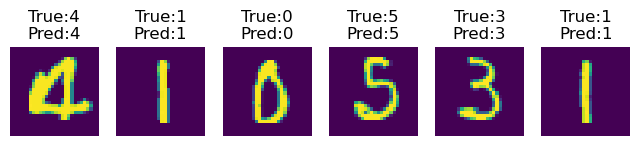

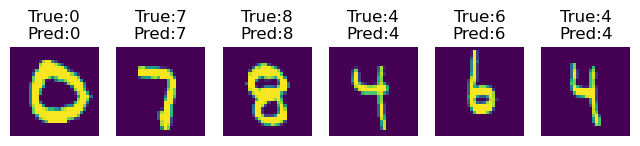

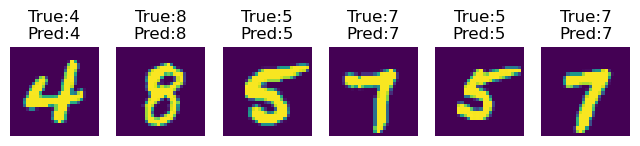

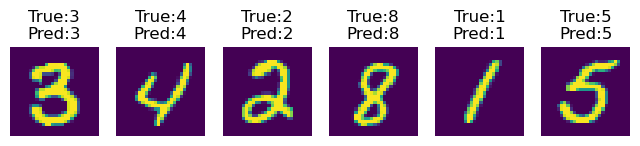

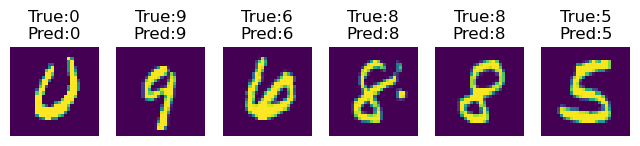

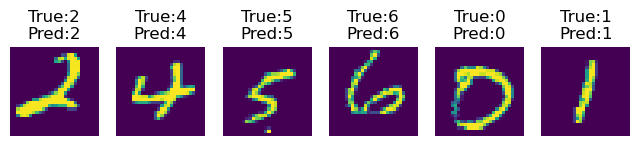

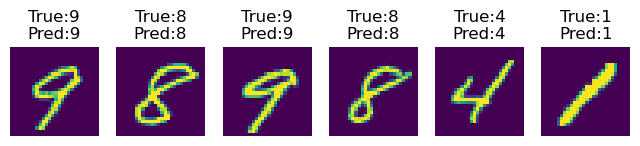

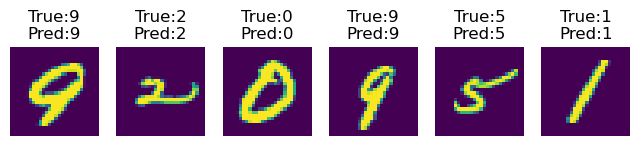

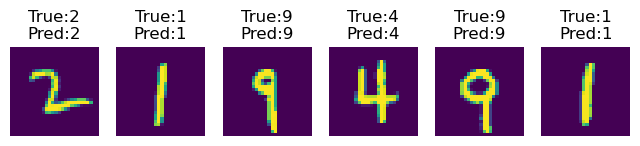

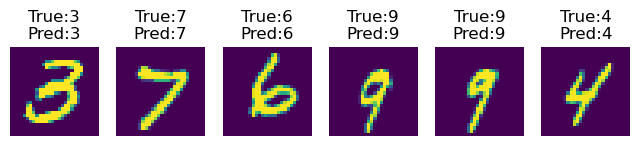

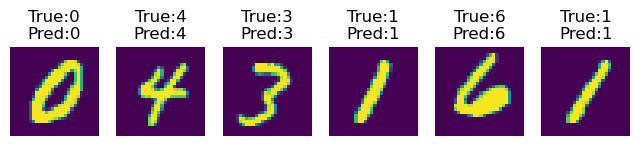

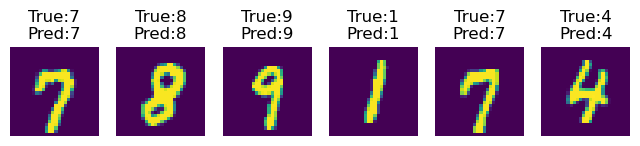

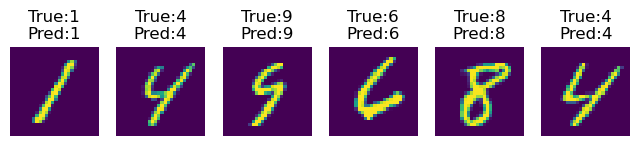

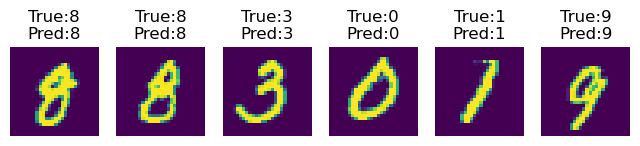

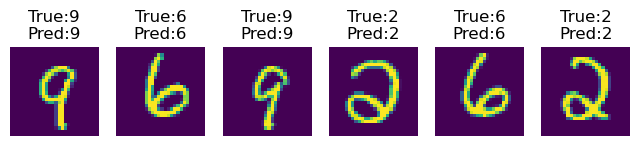

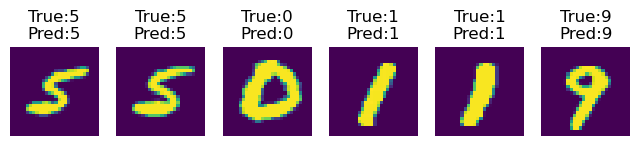

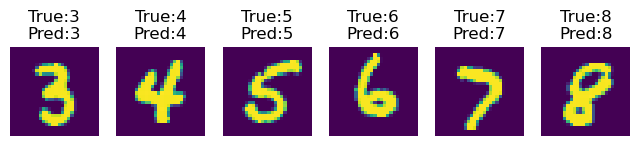

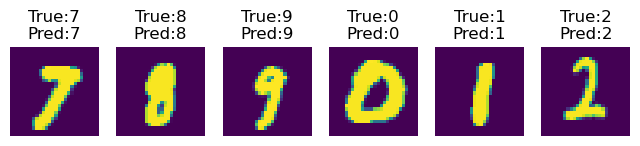

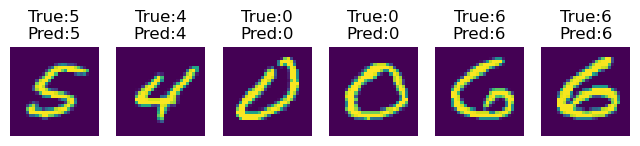

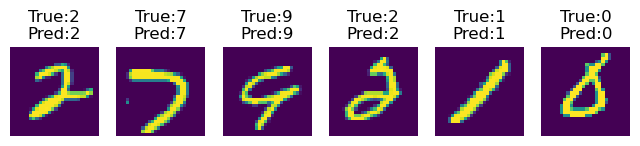

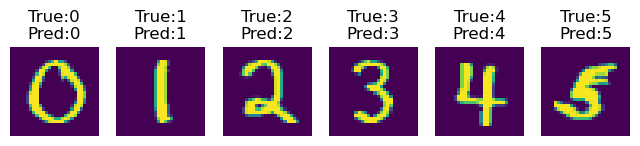

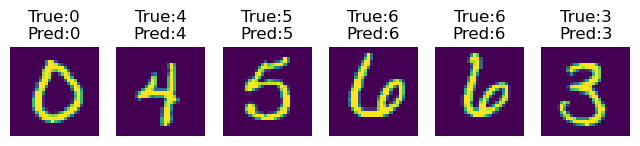

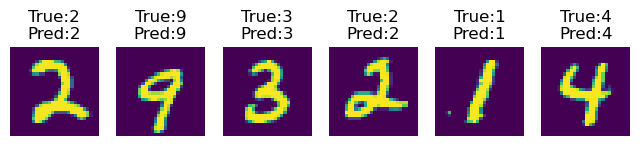

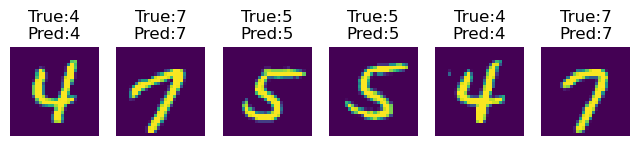

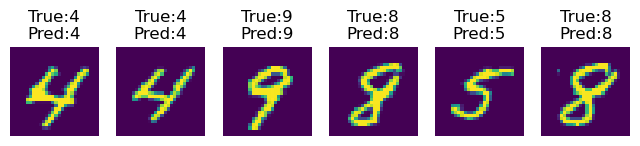

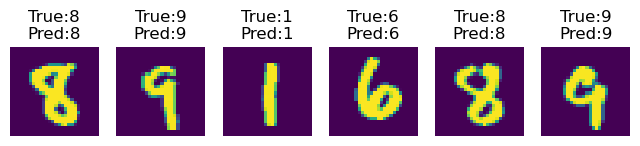

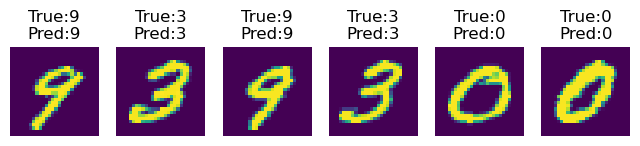

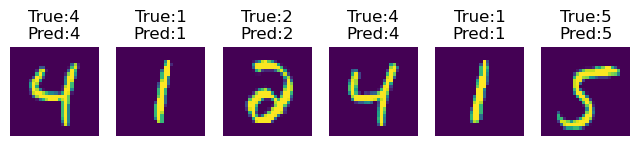

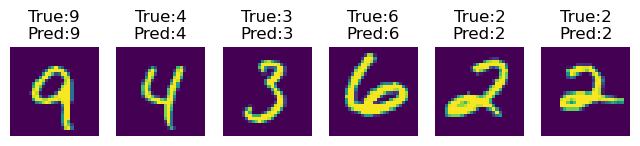

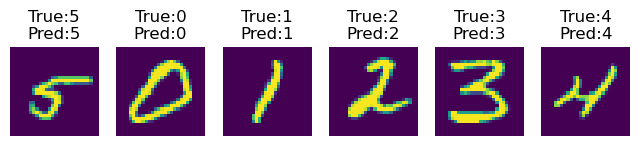

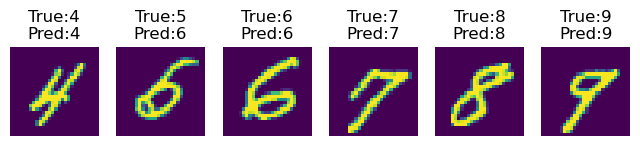

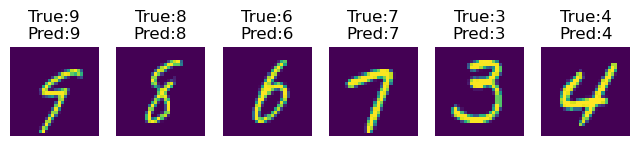

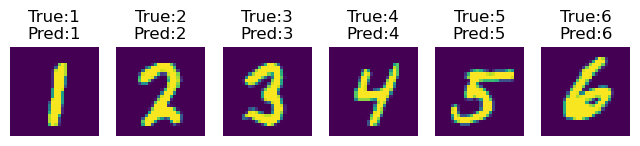

In [1]:
import torch, utils
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

transform = transforms.ToTensor()
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=128, shuffle=False)

net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size = 5),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(16, 32, kernel_size = 5),
    nn.MaxPool2d(kernel_size = 2),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 10)
)

def get_MINST_label(labels:list|torch.Tensor):
    label_list = [str(i) for i in range(10)]
    return [label_list[label] for label in labels]

def get_accuracy(y, y_hat):
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def test_accuracy(net, test_loader, device): # 返回测试集预测准确率
    metric = utils.Accumulator(2) # 正确预测 预测总数
    for X, y in test_loader:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        acc = get_accuracy(y, net(X))
        metric.add(acc, y.shape[0])
    return metric[0] / metric[1]
    
def train(net, train_loader, test_loader, lr, num_epochs, device, res:utils.ResVisualization):
    def init_weights(m):  # 内嵌一个初始化权重的函数
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)  # 使用Xavier初始化方法
    net.apply(init_weights)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=net.parameters(), lr = lr)
    net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = utils.Accumulator(3) # 训练损失 训练准确率 已训练样本数
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_function(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(loss*X.shape[0], get_accuracy(y, y_hat), X.shape[0])
        net.eval()
        test_acc = test_accuracy(net, test_loader, device)
        res.res_dict['train_loss'].append(metric[0]/metric[2])
        res.res_dict['train_acc'].append(metric[1]/metric[2])
        res.res_dict['test_acc'].append(test_acc)
        if epoch % 5 == 4:
            print(f"epoch:{epoch+1}, train_loss:{metric[0]/metric[2]:.3f}, train_acc:{metric[1]/metric[2]:.3f}, test_acc:{test_acc:.3f}")
    res.plot_res()
    
def predict(net, test_loader, device, n=6):
    net.eval()
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X).argmax(axis=1)
        fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(8,8))
        true_labels = get_MINST_label(y)
        pred_labels = get_MINST_label(y_hat)
        titles = [f'True:{true_label}\nPred:{pred_label}' for true_label, pred_label in zip(true_labels, pred_labels)]
        for i in range(n):
            axes[i].imshow(X[i].reshape((28,28)).cpu())
            axes[i].set_title(titles[i])
            axes[i].axis('off')

num_epochs = 20
lr = 0.1
device = utils.try_gpu()
res = utils.ResVisualization(legend_name=['train_loss', 'test_acc', 'train_acc'], num_epochs=num_epochs)
train(net, train_loader, test_loader, lr, num_epochs, device, res)
predict(net, test_loader, device)